# Using Fractional Cover (FC) and Spectral data to train a Random Forest (RF) Classifier for Land-cover Classification

The goal in this notebook is to train a classifier at the regional scale (Pacific) to get land-cover classification. The Pacific Islands face a critical lack of locally accurate land cover datasets. Existing global products are designed for continental or global scales and often fail to capture the nuanced land cover dynamics of the Pacific region. This leads to misclassification, underrepresentation of smaller land cover types, and unreliable data for local decision-making. The goal of our Random Forest classifier trained on fractional cover data and spectral data is to addresse this gap by providing a regionally tuned, high resolution land cover product specifically trained on Pacific island environments (e.g., Fiji, Cook Islands, Marshall Islands). 

In [25]:
import pandas as pd
import numpy as np 
import xarray as xr
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rasterio
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import glob
import rioxarray

In [4]:
fiji_path = "./data/preparation/fiji_dataset.csv"
marshall_path = "./data/preparation/marshall_dataset.csv"
cook_path = "./data/preparation/cook_dataset.csv"
palaos_path = "./data/preparation/palau_dataset.csv"

fj = pd.read_csv(fiji_path)
mh =  pd.read_csv(marshall_path)
ck =  pd.read_csv(cook_path)
pl =  pd.read_csv(palaos_path)

fj.head()

,Unnamed: 0,bs_pc_50,pv_pc_50,npv_pc_50,red,blue,green,nir08,swir16,emad,...,bs_may_aug,pv_may_aug,npv_may_aug,bs_sep_dec,pv_sep_dec,npv_sep_dec,dem,class_id,lulc,geometry
0,1,5.0,93.0,11.0,387.0,418.0,592.0,3960.0,1898.0,1428.47460,...,34.5,54.5,47.0,34.0,50.0,46.5,69.670860,1,forest,POINT (178.299596 -17.534893)
1,2,5.0,67.0,26.0,543.0,399.0,610.0,3547.0,1948.0,1435.79880,...,5.0,76.5,21.5,12.0,53.0,20.5,5.876614,2,cropland,POINT (177.511121 -17.550697)
2,3,2.0,89.0,10.0,214.0,208.0,404.0,3404.0,1030.0,414.70000,...,12.0,92.0,8.0,19.0,65.0,18.0,143.821720,1,forest,POINT (177.651039 -17.550286)
3,4,8.0,60.0,31.0,559.0,358.0,596.0,2667.0,1983.0,884.45544,...,7.5,59.0,32.0,20.0,49.0,30.0,35.900690,2,cropland,POINT (177.663759 -17.550244)
4,5,9.0,59.0,32.0,599.0,382.0,658.0,3156.0,2070.0,735.41100,...,4.0,74.0,21.0,7.0,73.0,17.0,8.685092,2,cropland,POINT (177.676479 -17.550201)


## 1. Data Preparation 

Data from Fiji, Cook Island, Marshall Island and Palaos were download to train a random forest that return land cover classification over the pacific region. We have for each island a shapefile containing point with the associated grountruth land cover label and position (lat, lon) and from the Sentinel-2 geomad, the RGB-NIR band were downloaded to compute the NDVI and NDWI and finally with .tif file with 3 bands for the annual fractionnal cover over each island. Then, we prepare the data using QGIS to have one dataset (shapefile) for each island containing for each point the following data :

- lat, lon
- Fractional Cover (bs : baresoil ; pv : photosynthetic vegetation ; npv : non-photosynthetic vegetation)
- NDVI
- NDWI
- NDBI (Normalized Difference Build Index)
- RGB-NIR (spectral bands)
- Label (**class-id : 1. Forest ; 2. Cropland ; 3. Grassland ; 4. Buildup ; 5. Baresoil ; 6. Water ; 7. Mangroves**)
- lulc (land-use, land-cover)
- Texture data (10 bands computed using Haralick Extraction Feature in QGIS --> GLCM)

The data are in the folder data, there 4 files (one per island).

In [5]:
# Create a table summarizing the lulc category distribution 

def count_lulc(df, island_name):
    counts = df["lulc"].value_counts().to_frame(name=island_name).T
    return counts

fj_counts = count_lulc(fj, "Fiji")
mh_counts = count_lulc(mh, "Marshall")
ck_counts = count_lulc(ck, "Cook")
pl_counts = count_lulc(pl, "Palaos")

summary = pd.concat([fj_counts, mh_counts, ck_counts, pl_counts], axis=0).fillna(0).astype(int)
summary["Total"] = summary.sum(axis=1)
summary = summary.sort_values(by="Total", ascending=False)

summary.head()

lulc,forest,grassland,cropland,mangroves,buildup,water,baresoil,Total
Fiji,2701,1450,523,444,129,37,19,5303
Cook,103,58,80,0,113,55,161,570
Palaos,69,69,59,13,42,33,171,456
Marshall,112,19,4,20,46,3,38,242


This summary table shows that there are a lot of data point in Fidji (on average 10 times more than in the other island) and that forest label is also over-represented. If we train a classifier directly on all the data, it will learn only charactheristics from this class and location and thus the classifier will be very bad on other class or other location. To avoid this, we need to balance the dataset before training the classifier.

### Deal with imbalance dataset

To build a good classifier that generalizes well across the Pacific, balancing data is important :

- Balancing between classes (so each LULC type is equally learned)
- Balancing between locations (so it doesn't overfit to any specific island)

But a minimum amount of data is needed in order to have a good classifier. Regarging the previous table, the less represented classes are water (155) and buildup (339). Based on this, the objective is to keep aroun 150-300 points per lulc. Finally to preserve spatial generalization, points from each island should be equally reprensented in each class.

I set manually : 

- Forest : Fiji : 80 ; Cook : 75 ; Palaos : 70 ; Marshall : 75 = 300
- Grassland : Fiji : 150 ; Cook : 59 ; Palaos : 77 ; Marshall : 22 = 308
- Mangroves : Fiji : 180 ; Cook : 0 ; Palaos : 18 ; Marshall : 6 = 204
- Cropland : Fiji : 150 ; Cook : 80 ; Palaos : 63 ; Marshall : 4 = 300
- Buildup : Fiji : 110 ; Cook : 110 ; Palaos : 40 ; Marshall : 40 = 300
- Water : Fiji : 39 ; Cook : 55 ; Palaos : 36 ; Marshall : 25 = 155
- Baresoil : Fiji : 15 ; Cook : 115 ; Palaos : 115 ; Marshall : 55 = 300

Following this distribution, the RF would be trained on 1867 data points.

Secondly, in order to improve performance, we wanted to increase the size of the training data. We therefore decided to maintain a dataset as balanced as possible between classes, but chose to ignore the balance between locations. Following this distribution, the RF is now trained on 3347 data points. Increasing the number of training points allows us to increase the number of features used during training without increasing the risk of suffering from the “curse of dimensionality.”

In [6]:
random.seed(42)

# balancing classes and location
"""
sampling_plan = {
    "forest":     {"Fiji": 80,  "Cook": 75,  "Palaos": 70,  "Marshall": 75},
    "grassland":  {"Fiji": 140, "Cook": 59,  "Palaos": 77,  "Marshall": 22},
    "mangroves":  {"Fiji": 180, "Cook": 0,   "Palaos": 18,  "Marshall": 6},
    "cropland":   {"Fiji": 155, "Cook": 80,  "Palaos": 63,  "Marshall": 4},
    "buildup":    {"Fiji": 110, "Cook": 110, "Palaos": 40,  "Marshall": 40},
    "water":      {"Fiji": 38,  "Cook": 55,  "Palaos": 36,  "Marshall": 17},
    "baresoil":   {"Fiji": 15,  "Cook": 115, "Palaos": 115, "Marshall": 15}
}
"""

# balancing classes
sampling_plan = {
    "forest":     {"Fiji": 300,  "Cook": 100,  "Palaos": 69,  "Marshall": 100},
    "grassland":  {"Fiji": 400, "Cook": 58,  "Palaos": 59,  "Marshall": 19},
    "mangroves":  {"Fiji": 400, "Cook": 0,   "Palaos": 13,  "Marshall": 19},
    "cropland":   {"Fiji": 430, "Cook": 80,  "Palaos": 59,  "Marshall": 4},
    "buildup":    {"Fiji": 129, "Cook": 113, "Palaos": 40,  "Marshall": 40},
    "water":      {"Fiji": 30,  "Cook": 50,  "Palaos": 32,  "Marshall": 3},
    "baresoil":   {"Fiji": 15,  "Cook": 160, "Palaos": 171, "Marshall": 38}
}
island_dfs = {
    "Fiji": fj,
    "Cook": ck,
    "Palaos": pl,
    "Marshall": mh
}


samples = []


for lulc_class, island_counts in sampling_plan.items():
    for island, n_points in island_counts.items():
        if n_points == 0:
            continue
        df = island_dfs[island]
        df_filtered = df[df["lulc"] == lulc_class]

        if len(df_filtered) < n_points:
            raise ValueError(f"Not enough data for {lulc_class} in {island} (needed {n_points}, available {len(df_filtered)})")

        # Convert to list of rows (dicts), sample with random
        filtered_list = df_filtered.to_dict(orient="records")
        selected = random.sample(filtered_list, n_points)

        # Reconvert to DataFrame and add island info
        selected_df = pd.DataFrame(selected)
        selected_df["island"] = island
        samples.append(selected_df)

# Concatenate all sampled rows
train_df = pd.concat(samples, ignore_index=True)

# Check result
print("Final shape:", train_df.shape)
print("Class counts:\n", train_df["lulc"].value_counts())
print("Island counts:\n", train_df["island"].value_counts())


Final shape: (2931, 30)
Class counts:
 lulc
cropland     573
forest       569
grassland    536
mangroves    432
baresoil     384
buildup      322
water        115
Name: count, dtype: int64
Island counts:
 island
Fiji        1704
Cook         561
Palaos       443
Marshall     223
Name: count, dtype: int64


In [7]:
train_df = train_df.drop(columns=['Unnamed: 0'])
df = train_df.sample(frac=1).reset_index(drop=True)
df.head()

,bs_pc_50,pv_pc_50,npv_pc_50,red,blue,green,nir08,swir16,emad,smad,...,pv_may_aug,npv_may_aug,bs_sep_dec,pv_sep_dec,npv_sep_dec,dem,class_id,lulc,geometry,island
0,8.0,90.0,9.0,250.0,289.0,463.0,3675.0,1416.0,695.56290,0.001138,...,70.0,17.0,16.5,56.5,19.5,911.109400,1,forest,POINT (177.983062 -17.792939),Fiji
1,46.0,26.0,26.0,1828.0,1618.0,1879.0,2371.0,2070.0,1028.92480,0.004175,...,29.0,53.5,32.0,41.0,45.0,2.125365,5,baresoil,POINT (134.50732591550135 7.364778388411099),Palaos
2,7.0,74.0,20.0,396.0,321.0,561.0,3195.0,1776.0,1169.77010,0.006445,...,69.5,26.0,17.0,52.0,29.0,118.264885,2,cropland,POINT (177.60004 -17.513841),Fiji
3,9.0,61.0,29.0,478.0,291.0,490.0,2286.0,969.0,745.73615,0.002493,...,58.5,29.0,9.0,54.0,31.5,1.350468,5,baresoil,POINT (177.59996 -17.489437),Fiji
4,30.0,58.0,6.0,996.0,851.0,1030.0,3209.0,2262.0,1107.36300,0.003548,...,57.0,20.5,21.0,55.0,15.5,65.170840,4,buildup,POINT (177.587323 -17.513879),Fiji


In [6]:
# save the training dataset
df.to_excel('./data/training_data.xlsx')

## 2. Training RF Classifier

Initial training was performed using only Fractional Cover (FC) features. While the model learned general patterns, it failed to capture class-specific characteristics, resulting in low accuracy (~55%). To improve performance, spectral features (RGB bands) and vegetation/water indices (NDVI, NDWI) were added. This enriched the feature space with reflectance-based and moisture-related information, increasing accuracy to ~65%. However, the model still struggled to distinguish cropland, grassland, and forest—likely due to their spectral similarity.

To better capture spatial context, NDVI texture features were introduced using GLCM (Haralick features computed in QGIS). A [study](https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1278314) suggests GLCM mean is most effective for classification, with contrast and entropy adding value in edge-rich or detailed contexts. Since band 1 appears to represent the mean, it was retained as texture1. A PCA-based reduction of all texture bands was tested but performed poorly, likely due to loss of spatial nuance. So only texture1 was kept.

Vegetation indices such as EVI and SAVI were also tested to better discriminate dense versus sparse vegetation. However, their inclusion led to misclassification, especially overprediction of cropland, suggesting feature redundancy or class confusion. We only keep one between the two, to avoid the feature redundancy. NDBI, intended to improve separation of bare soil, lead to more forest pixel classify as baresoil or cropland but increase overall performance.

Alternative classifiers (XGBoost, SVM) and ensemble stacking were tested but underperformed compared to Random Forest, possibly due to the small or imbalanced training dataset.

The NDVI class-wise mean per island (ndvi_mean) was added. While this greatly boosted accuracy (~96%), it dominated feature importance, causing overfitting by allowing the model to learn class identity rather than general patterns.

Finally, the last attempt to increase overall performance was to add temporality to the data in order to account for yearly changes (wet season and dry season). The fractional cover temporal data were computed (see part 5 of the code) for three seasons: January to April (wet season), May to August, and September to December (dry season). Moreover, we also decided to add the monthly NDVI, as it could help provide more information about seasonal changes over forests and also take into account the harvesting season (drop in cropland NDVI).

In [8]:
print(f'Possible features for training :\n {df.columns.values[:]}')

Possible features for training :
 ['bs_pc_50' 'pv_pc_50' 'npv_pc_50' 'red' 'blue' 'green' 'nir08' 'swir16'
 'emad' 'smad' 'bcmad' 'ndvi' 'mndwi' 'evi' 'ndbi' 'bs_jan_apr'
 'pv_jan_apr' 'npv_jan_apr' 'bs_may_aug' 'pv_may_aug' 'npv_may_aug'
 'bs_sep_dec' 'pv_sep_dec' 'npv_sep_dec' 'dem' 'class_id' 'lulc'
 'geometry' 'island']


In [27]:
# Select Features and Labels 
#features = df[['bs_pc_50','pv_pc_50', 'npv_pc_50', 'ndvi_jan1', 'ndvi_feb1',  'ndvi_mar1', 'ndvi_apr1', 'ndvi_may1','ndvi_jun1','ndvi_jul1','ndvi_aug1','ndvi_sep1', 'ndvi_oct1', 'ndvi_nov1', 'ndvi_dec1',
#                'ndwi1', 'ndbi1', 'red1', 'green1', 'blue1', 'pv_jan_apr', 'pv_sep_dec', 'bs_jan_apr', 'bs_may_aug', 'bs_sep_dec', 'npv_jan_ap', 'npv_may_au', 'npv_sep_de', 'ndvi1']]

features = df[['bs_pc_50', 'pv_pc_50', 'npv_pc_50', 'red', 'blue', 'green','nir08', 'swir16', 'emad', 'smad' ,'bcmad' ,'ndvi', 'mndwi', 'evi' ,'ndbi',
               'bs_jan_apr' ,'pv_jan_apr' ,'npv_jan_apr', 'bs_may_aug', 'pv_may_aug', 'npv_may_aug', 'bs_sep_dec', 'pv_sep_dec', 'npv_sep_dec' ,'dem']]
labels = df['class_id']

# Train/Test Split 
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.15, random_state=42)

# Train Random Forest Classifier 
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=42,
    class_weight='balanced')

rf.fit(X_train, y_train)

# Make Predictions 
y_pred = rf.predict(X_val)

# Performance  Metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)
report = classification_report(y_val, y_pred)


# Results 
print("Random Forest Classifier Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")
print("\nClassification Report:\n", report)


Random Forest Classifier Performance
Accuracy: 80.00%
Weighted F1-score: 79.93%
Cohen's Kappa: 0.761

Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.85      0.80        84
           2       0.75      0.77      0.76        92
           3       0.69      0.64      0.66        80
           4       0.83      0.71      0.77        42
           5       0.83      0.94      0.88        52
           6       0.90      0.83      0.86        23
           7       0.98      0.91      0.95        67

    accuracy                           0.80       440
   macro avg       0.82      0.81      0.81       440
weighted avg       0.80      0.80      0.80       440



In [21]:
# Get Feature Importances
importances = rf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print Table
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
        Feature  Importance
14          dem    0.082134
7        swir16    0.078332
13         ndbi    0.076435
10         ndvi    0.054321
3           red    0.051273
6         nir08    0.047100
11        mndwi    0.044389
4          blue    0.043857
1      pv_pc_50    0.042708
12          evi    0.042631
16   pv_jan_apr    0.042069
5         green    0.041009
8          smad    0.036444
9         bcmad    0.035311
22   pv_sep_dec    0.033723
0      bs_pc_50    0.030515
21   bs_sep_dec    0.030370
17  npv_jan_apr    0.029983
18   bs_may_aug    0.029790
23  npv_sep_dec    0.027473
19   pv_may_aug    0.027112
20  npv_may_aug    0.026381
15   bs_jan_apr    0.023444
2     npv_pc_50    0.023198


Highly correlated feature pairs (>|0.95|):
   Feature1 Feature2  Correlation
69      red     blue     0.968083
70      red    green     0.971385
90     blue    green     0.980445


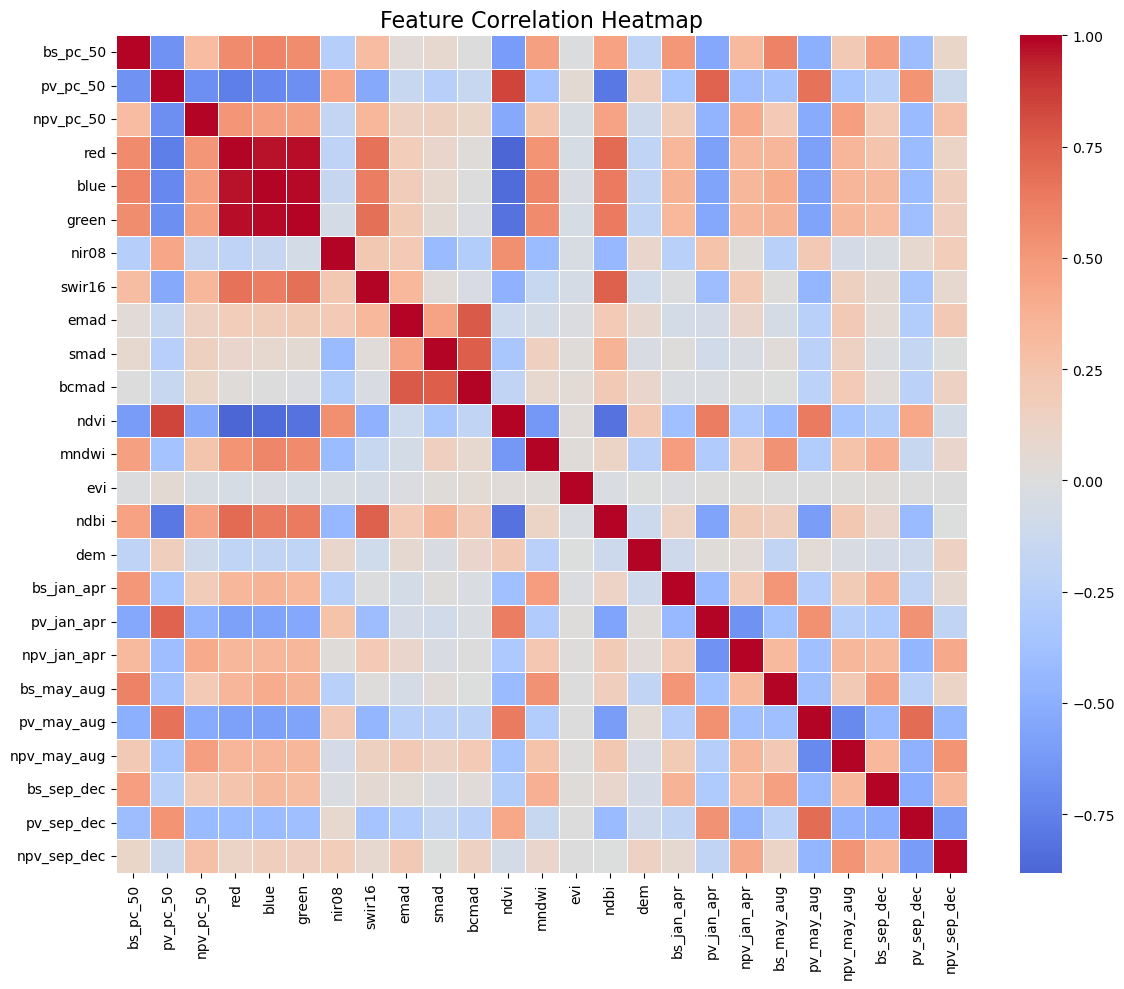

In [11]:
df_features = features
corr_matrix = df_features.corr()

threshold = 0.95
corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # keep upper triangle
    .stack()  # convert to long format
    .reset_index()
)
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]

print("Highly correlated feature pairs (>|0.95|):")
print(high_corr)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,        
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

High collinearity between features can negatively impact model performance by introducing redundant information and making the model more sensitive to noise. This can lead to unstable predictions and reduced generalization. However, we chose to retain the monthly NDVI despite its high correlation, as it captures seasonal dynamics, critical for distinguishing land-cover classes such as cropland and forest. Similarly, although RGB bands are highly correlated, each band carries subtle but complementary spectral information that can improve class separability, especially when combined with vegetation and moisture indices.

## 3. Testing and Show Results

In [67]:
test_path = './data/preparation/fiji_test_dataset.csv'
fiji_test = pd.read_csv(test_path)
fiji_test.head()

,Unnamed: 0,bs_pc_50,pv_pc_50,npv_pc_50,red,blue,green,nir08,swir16,emad,...,bs_may_aug,pv_may_aug,npv_may_aug,bs_sep_dec,pv_sep_dec,npv_sep_dec,dem,class_id,lulc,geometry
0,11,6.0,98.0,7.0,263.0,268.0,498.0,3732.0,1111.0,437.94522,...,7.0,86.0,23.0,15.5,60.5,60.5,5.639843,2,cropland,POINT (179.780273 -16.215161)
1,21,6.0,92.0,4.0,284.0,311.0,477.0,3979.0,1300.0,1008.63850,...,9.0,79.0,65.0,7.0,67.5,28.0,28.763420,1,forest,POINT (179.780445 -16.22735)
2,33,6.0,90.0,3.0,267.0,317.0,573.0,4403.0,1549.0,896.54250,...,20.0,49.0,61.0,15.5,69.5,57.0,50.373660,1,forest,POINT (179.742761 -16.240034)
3,36,12.0,84.0,14.0,286.0,288.0,426.0,3048.0,1328.0,840.69030,...,5.0,53.5,26.0,19.0,71.0,16.0,19.020502,1,forest,POINT (179.75538 -16.23987)
4,37,5.0,84.0,10.0,303.0,307.0,464.0,3339.0,1270.0,882.46410,...,7.0,79.5,12.0,22.5,64.5,14.0,32.933216,1,forest,POINT (179.767998 -16.239705)


In [69]:
#X_test = fiji_test[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', 'ndvi_mean', 'ndvi_std'
#X_test = fiji_test[['bs_pc_50','pv_pc_50','npv_pc_50', 'pv_jan_apr', 'pv_sep_dec', 'ndvi1', 'ndbi1', 'ndwi1', 'red1','green1', 'blue1', 'texture1', 'ndwi1', 'savi']]
#X_test = fiji_test[['bs_pc_50','pv_pc_50', 'npv_pc_50', 'ndvi_jan1', 'ndvi_feb1',  'ndvi_mar1', 'ndvi_apr1', 'ndvi_may1','ndvi_jun1','ndvi_jul1','ndvi_aug1','ndvi_sep1', 'ndvi_oct1', 'ndvi_nov1', 'ndvi_dec1',
#                'ndwi1', 'ndbi1', 'red1', 'green1', 'blue1', 'pv_jan_apr', 'pv_sep_dec', 'bs_jan_apr', 'bs_may_aug', 'bs_sep_dec', 'npv_jan_ap', 'npv_may_au', 'npv_sep_de', 'ndvi1']]

X_test = fiji_test[['bs_pc_50', 'pv_pc_50', 'npv_pc_50', 'red', 'blue', 'green','nir08', 'swir16', 'emad', 'smad' ,'bcmad' ,'ndvi', 'mndwi', 'evi' ,'ndbi',
               'bs_jan_apr' ,'pv_jan_apr' ,'npv_jan_apr', 'bs_may_aug', 'pv_may_aug', 'npv_may_aug', 'bs_sep_dec', 'pv_sep_dec', 'npv_sep_dec' , 'dem']]

# Predict classes with trained model
fiji_test['predicted_class'] = rf.predict(X_test)
fiji_test.head()

,Unnamed: 0,bs_pc_50,pv_pc_50,npv_pc_50,red,blue,green,nir08,swir16,emad,...,pv_may_aug,npv_may_aug,bs_sep_dec,pv_sep_dec,npv_sep_dec,dem,class_id,lulc,geometry,predicted_class
0,11,6.0,98.0,7.0,263.0,268.0,498.0,3732.0,1111.0,437.94522,...,86.0,23.0,15.5,60.5,60.5,5.639843,2,cropland,POINT (179.780273 -16.215161),7
1,21,6.0,92.0,4.0,284.0,311.0,477.0,3979.0,1300.0,1008.63850,...,79.0,65.0,7.0,67.5,28.0,28.763420,1,forest,POINT (179.780445 -16.22735),7
2,33,6.0,90.0,3.0,267.0,317.0,573.0,4403.0,1549.0,896.54250,...,49.0,61.0,15.5,69.5,57.0,50.373660,1,forest,POINT (179.742761 -16.240034),1
3,36,12.0,84.0,14.0,286.0,288.0,426.0,3048.0,1328.0,840.69030,...,53.5,26.0,19.0,71.0,16.0,19.020502,1,forest,POINT (179.75538 -16.23987),1
4,37,5.0,84.0,10.0,303.0,307.0,464.0,3339.0,1270.0,882.46410,...,79.5,12.0,22.5,64.5,14.0,32.933216,1,forest,POINT (179.767998 -16.239705),1


In [70]:
y_true = fiji_test['class_id']
y_pred = fiji_test['predicted_class']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print("Test Set Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")

from sklearn.metrics import f1_score

labels = np.unique(y_true)

for label in labels:
    mask = y_true == label
    acc_label = (y_pred[mask] == y_true[mask]).mean()
    f1_label = f1_score(y_true, y_pred, labels=[label], average='weighted')
    print(f"Class {label}: Accuracy = {acc_label:.2%}, F1-score = {f1_label:.2%}")

Test Set Performance
Accuracy: 75.97%
Weighted F1-score: 75.77%
Cohen's Kappa: 0.610
Class 1: Accuracy = 87.89%, F1-score = 86.78%
Class 2: Accuracy = 50.94%, F1-score = 40.75%
Class 3: Accuracy = 28.07%, F1-score = 32.88%
Class 4: Accuracy = 16.67%, F1-score = 23.53%
Class 5: Accuracy = 0.00%, F1-score = 0.00%
Class 6: Accuracy = 80.00%, F1-score = 72.73%
Class 7: Accuracy = 88.80%, F1-score = 91.63%


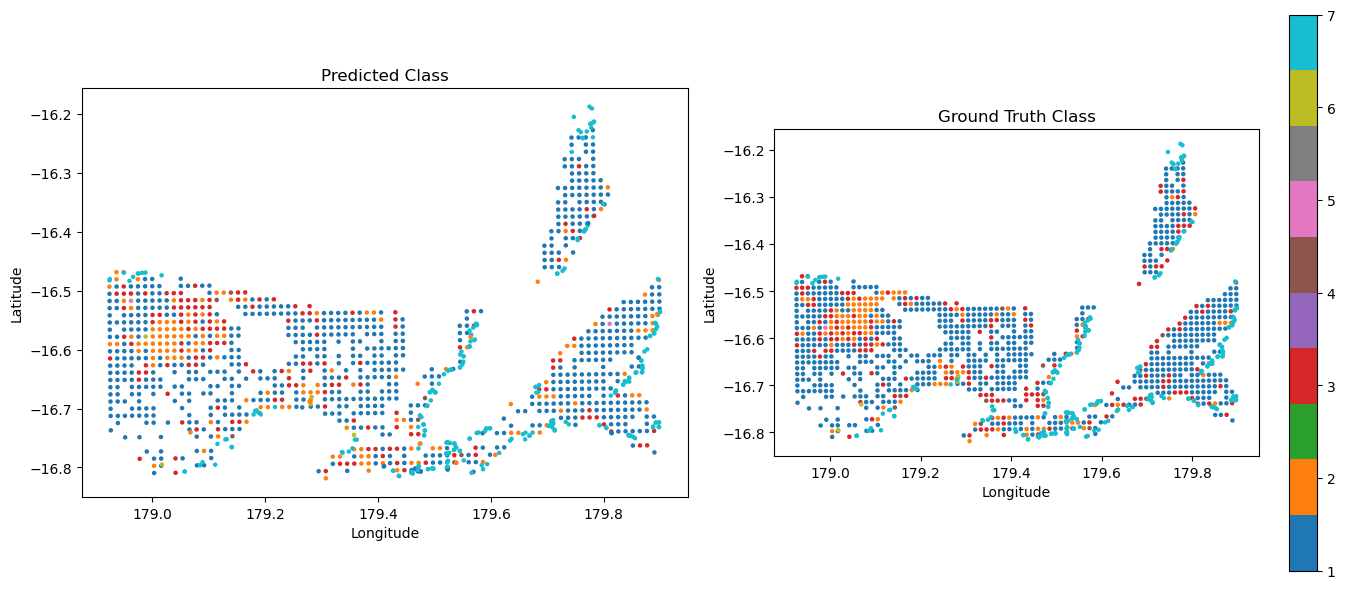

In [17]:
import geopandas as gpd
from shapely import wkt

# Convert geometry column from WKT string to shapely geometries
fiji_test["geometry"] = fiji_test["geometry"].apply(wkt.loads)

# Now create a proper GeoDataFrame
gdf = gpd.GeoDataFrame(fiji_test, geometry="geometry", crs="EPSG:4326")

# Plot predicted vs ground truth
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Predicted
gdf.plot(
    column="predicted_class",
    cmap="tab10",
    legend=False,
    ax=axes[0],
    markersize=5,
)
axes[0].set_title("Predicted Class")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Ground truth
gdf.plot(
    column="class_id",
    cmap="tab10",
    legend=True,
    ax=axes[1],
    markersize=5,
)
axes[1].set_title("Ground Truth Class")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

## 6. Test RF Classifier on Image 

In this part, we prepare and stack all the bands FC and Spectral Images to test the RF classifier on an image

In [45]:
import sys
from pystac_client import Client
import depal_ck as dep
from odc.stac import load
from shapely import geometry
from dea_tools.dask import create_local_dask_cluster
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/philippinel@spc.int/proxy/41869/status,
Dashboard: /user/philippinel@spc.int/proxy/41869/status,Workers: 1
Total threads: 8,Total memory: 57.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42191,Workers: 0
Dashboard: /user/philippinel@spc.int/proxy/41869/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33425,Total threads: 8
Dashboard: /user/philippinel@spc.int/proxy/40757/status,Memory: 57.21 GiB
Nanny: tcp://127.0.0.1:33423,


In [18]:
path =  "./data/preparation/noumea.nc"
datasets = xr.open_dataset(path).load() 
datasets = datasets.drop_vars('spatial_ref')
datasets

<xarray.Dataset> Size: 54MB
Dimensions:      (x: 817, y: 486, time: 1)
Coordinates:
  * x            (x) float64 7kB 166.3 166.3 166.3 166.3 ... 166.5 166.5 166.5
  * y            (y) float64 4kB -22.21 -22.21 -22.21 ... -22.34 -22.34 -22.34
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/25)
    bs_pc_50     (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    pv_pc_50     (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    npv_pc_50    (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    red          (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    ...           ...
    pv_may_aug   (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    npv_may_aug  (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    bs_sep_dec   (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    pv_sep_dec   (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    npv_sep_dec  (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    dem          (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan

In [40]:
# PREDICTIONS
train_features = ['bs_pc_50', 'pv_pc_50', 'npv_pc_50', 
                  'red', 'blue', 'green', 'nir08', 'swir16', 'emad',
                  'smad', 'bcmad', 'ndvi', 'mndwi', 'evi', 'ndbi',
                  'bs_jan_apr', 'pv_jan_apr', 'npv_jan_apr', 
                  'bs_may_aug', 'pv_may_aug', 'npv_may_aug', 
                  'bs_sep_dec', 'pv_sep_dec', 'npv_sep_dec',
                  'dem']


missing_features = [f for f in train_features if f not in datasets.data_vars]
if missing_features:
    raise ValueError(f"Missing features in the dataset: {missing_features}")

stacked = np.stack([np.squeeze(datasets[f].values) for f in train_features], axis=0)
bands, ysize, xsize = stacked.shape
X_test = stacked.reshape(bands, -1).T 

# Create Prediction Mask 
valid_mask = np.all(np.isfinite(X_test), axis=1)
X_valid = X_test[valid_mask]

# Predict only on valid pixels
pred_flat = np.full(X_test.shape[0], np.nan) 
pred_flat[valid_mask] = rf.predict(X_valid)  

# Reshape back 
pred_raster = pred_flat.reshape(ysize, xsize)

In [56]:
unique_classes = np.unique(pred_raster[~np.isnan(pred_raster)])
print(unique_classes)

[1. 2. 3. 4. 5. 6. 7.]


In [42]:
catalog = "https://stac.staging.digitalearthpacific.io"
client = Client.open(catalog)
collections = client.get_collections()

aoi = dep.get_country_admin_boundary('New Caledonia', 'Commune', "Nouméa")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)
gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')

In [43]:
# RGB 
items = client.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks) 
data = data.rio.write_crs("EPSG:3832")
data = data.sel(time="2024-01-01")

# Ensure CRS matches
aoi = aoi.to_crs("EPSG:3832")

# Crop to AOI bounding box (but keep water!)
data_cropped = data.rio.clip_box(
    minx=aoi.total_bounds[0],
    miny=aoi.total_bounds[1],
    maxx=aoi.total_bounds[2],
    maxy=aoi.total_bounds[3],
)

red = data_cropped["red"].astype("float32").values
green = data_cropped["green"].astype("float32").values
blue = data_cropped["blue"].astype("float32").values

rgb = np.stack([red, green, blue], axis=-1)
rgb_norm = np.clip(rgb / np.percentile(rgb, 99), 0, 1)

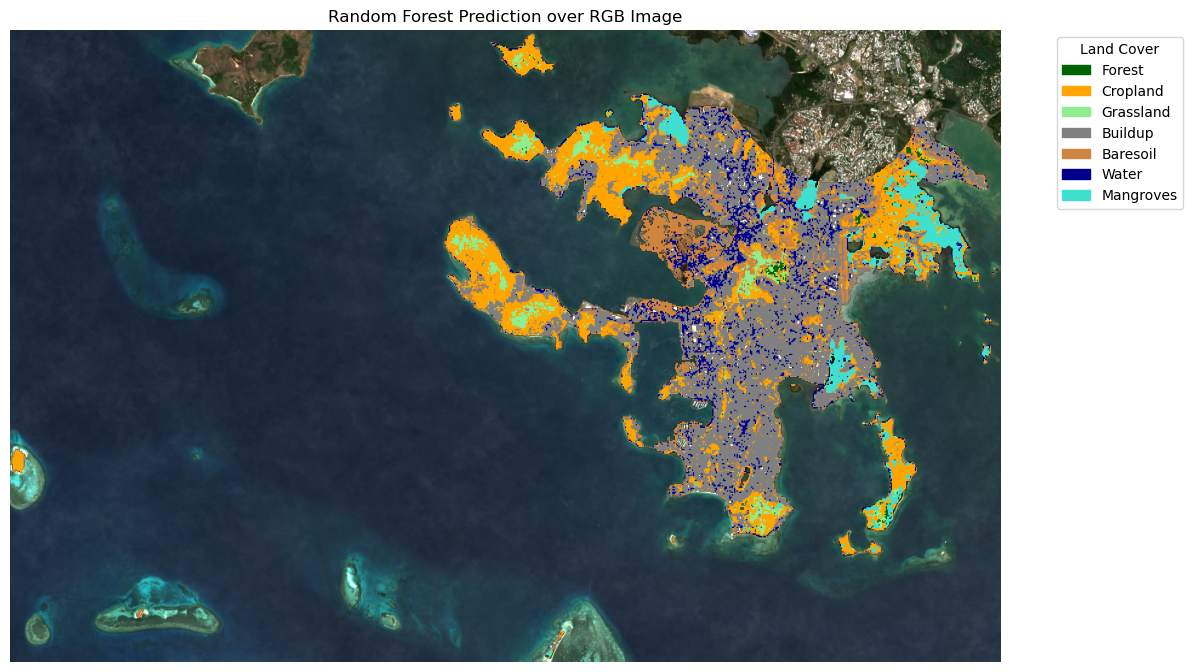

In [66]:
class_labels = {
    1: "Forest",
    2: "Cropland",
    3: "Grassland",
    4: "Buildup",
    5: "Baresoil",
    6: "Water",
    7: "Mangroves"
}


colors = [
    "darkgreen",   
    "orange",      
    "lightgreen",  
    "grey",       
    "peru",        
    "darkblue",    
    "turquoise"    
]
cmap = ListedColormap(colors)


fig, ax = plt.subplots(figsize=(12, 12))

# RGB 
ax.imshow(rgb_norm, extent=[0, rgb_norm.shape[1], rgb_norm.shape[0], 0])

# Prediction 
im = ax.imshow(pred_raster , cmap=cmap, alpha=1,  extent=[0, rgb_norm.shape[1], rgb_norm.shape[0], 0])

ax.axis("off")
ax.set_title("Random Forest Prediction over RGB Image")

# Legend
patches = [mpatches.Patch(color=colors[i-1], label=class_labels[i]) for i in class_labels.keys()]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Land Cover")

plt.tight_layout()
plt.show()
